# Importing libraries

The following imports are for making a quick inline plot at the end

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

This imports the [col](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.col) 
function which is used later to get the column object for something that is calculated as part
of the pipeline and does not yet have a name that can be refered to.

In [2]:
from pyspark.sql.functions import col

# Reading in the iDigBio data frame

There is a [parquet file](https://parquet.apache.org/) stored on the HDFS file system used by the Spark cluster that already has a copy of iDigBio data in it. This is a testing export and does not have all of the columns from iDigBio but it has a lot of the commonly used ones.

In [3]:
# Confirm we've started SPARK and created a SQL context that can be used
sqlContext

In [15]:
idb_df = sqlContext.read.parquet("/guoda/data/idigbio-20171209T023310.parquet")

In [16]:
idb_df.count()

106202428

In [17]:
checklists = (idb_df
              .select(idb_df.countrycode, idb_df.scientificname)
              .filter(idb_df.countrycode != "")
              .groupBy(idb_df.countrycode, idb_df.scientificname)
              .count()
              )

In [18]:
print(checklists.count())
#checklists.head(10)

5803132


In [19]:
checklists.head(10)

[Row(countrycode='usa', scientificname='bolboschoenus maritimus', count=733),
 Row(countrycode='usa', scientificname='penstemon pseudospectabilis', count=366),
 Row(countrycode='usa', scientificname='rhus aromatica', count=2281),
 Row(countrycode='usa', scientificname='chorizanthe spinosa', count=180),
 Row(countrycode='usa', scientificname='mucronea californica', count=445),
 Row(countrycode='usa', scientificname='ericameria nauseosa var. hololeuca', count=623),
 Row(countrycode='usa', scientificname='carex divulsa subsp. divulsa', count=32),
 Row(countrycode='usa', scientificname='keckiella lemmonii', count=408),
 Row(countrycode='usa', scientificname='lasthenia minor', count=641),
 Row(countrycode='usa', scientificname='tanacetum parthenium', count=297)]

# Filtering and summarizing data

All the iDigBio data is first filtered to only those records related to arthopods. Notice that there are two syntaxes for the [filter](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.filter) function and each line uses one of them. The SQL-style IN clause was an easier way of expressing the country codes than a set of equality and or operations.

In [20]:
arthropods = (idb_df
              .filter(idb_df.phylum == "arthropoda")
              .filter("countrycode IN ('usa', 'can', 'mex')")
              )
arthropods.count()

8941230

The syntax for summarizing data also resembles SQL. (In fact, all this can be done with an actual SQL statement using registerTempTable() and sqlContext.sql() if you wanted to work only with SQL syntax.) Notice the use of the col() function to get the newly calculated column of counts. This is needed because there is no column arthropods.counts, the column only exists in the context of the calulation before the assignment to species_counts happens.

In [21]:
species_counts = (arthropods
                  .groupBy(arthropods.scientificname)
                  .count()
                  .orderBy(col("count"), ascending=False)
                  )

In [22]:
print(species_counts.count())
species_counts.head(10)

260629


[Row(scientificname=None, count=367960),
 Row(scientificname='aphodius', count=49429),
 Row(scientificname='megaselia', count=47294),
 Row(scientificname='diptera', count=40279),
 Row(scientificname='undetermined', count=39643),
 Row(scientificname='hymenoptera', count=32855),
 Row(scientificname='ichneumonidae', count=27857),
 Row(scientificname='georgecraigius epactius', count=22113),
 Row(scientificname='empoasca', count=21334),
 Row(scientificname='undetermined sp.', count=19327)]

# Graph the distribution

To make a quick graph, the Spark dataframe needs to be converted to a structure that graphing libraries like matplotlib understand. The topPandas() method of a dataframe will convert the data to a Pandas dataframe but this is a single object in the memory of the notebook server, it is not on the Spark cluster. Additionally, graphing more than 10,000 things is unreadable so be very sure to cut down the size of the dataframe before converting to Pandas. Here only species with more than 100 occurences are graphed.

In [23]:
top_species_for_graph = (species_counts
                         .filter("count > 500")
                         .toPandas()
                         )
print(top_species_for_graph.shape)

(2686, 2)


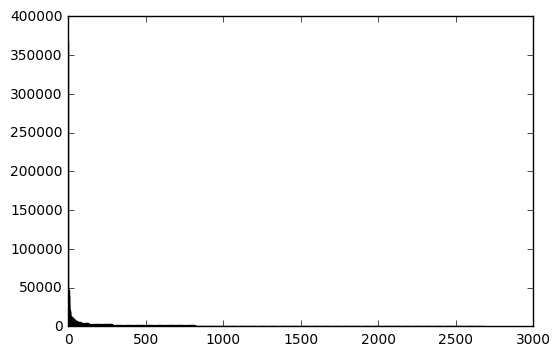

In [24]:
ax = plt.bar(left=top_species_for_graph.index,
            height=top_species_for_graph["count"])

# Save the list

Finally, save the full dataframe out as a CSV file for other uses. Right now this writes the file to the HDFS cluster for which there is no user access. Please email mcollins@acis.ufl.edu to get a copy of your files.

In [14]:
(species_counts
 .write
 .format("com.databricks.spark.csv")
 .mode("overwrite")
 .option("header", "true")
 .save("/outputs/species_counts.csv")
)